In [1]:
import warnings
from collections import namedtuple
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
torch.set_num_threads(2)
import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.utils import save_image
import params
from ipylab import JupyterFrontEnd

import argparse
import time
import sys
import torch
import torch.nn.functional as F
import torch.optim as optim


# %run meta_ood/meta_ood_master/config
from meta_ood.meta_ood_master.config import config_training_setup
from meta_ood.meta_ood_master.src.imageaugmentations import Compose, Normalize, ToTensor, RandomCrop, RandomHorizontalFlip
from meta_ood.meta_ood_master.src.model_utils import load_network
from torch.utils.data import DataLoader

app = JupyterFrontEnd()
app.commands.execute('notebook:render-all-markdown')

In [15]:
class Normalize(object):
    def __init__(self):
        self.mean=(0.485, 0.456, 0.406)
        self.std=(0.299,0.224,0.225) #from PyTorch Website
    def __call__(self, img_sem):
        img, sem=img_sem
        img=transforms.functional.normalize(img, self.mean, self.std)
        return(img,sem)

class ToTensor(object):
    def __init__(self):
        pass
    def __call__(self, img_sem):
        img, sem=img_sem
        img=transforms.functional.to_tensor(img)
        sem=256*transforms.functional.to_tensor(sem)
        sem=sem.squeeze(0).long()
        return(img, sem)

class Resize(object):
    def __init__(self,size):
        self.size=size
    def __call__(self, img_sem):
        img, sem=img_sem
        img=img.resize(self.size, Image.BILINEAR)
        sem=sem.resize(self.size, Image.NEAREST)
        return(img,sem)

class Cityscapes(torch.utils.data.Dataset):
    def __init__(self, root, split):
        self.root =root
        self.split=split
        self.images=[]
        self.targets=[]
        image_dir=os.path.join(root, 'leftImg8bit',split)
        target_dir=os.path.join(root,'gtFine',split)
        for city in os.listdir(image_dir):
            city_image_dir=os.path.join(image_dir, city)
            city_target_dir=os.path.join(target_dir, city)
            for image_name in os.listdir(city_image_dir):
                image_path=os.path.join(city_image_dir,image_name)
                target_name=image_name.replace('leftImg8bit','gtFine_labelIds')
                target_path=os.path.join(city_target_dir, target_name)
                if target_name.endswith('_gtFine_labelIds.png'):
                    self.images.append(image_path)
                    self.targets.append(target_path)
        self.images.sort()
        self.targets.sort()
        
        self.resize=Resize((2048,1024))####((512,256))
        self.to_tensor=ToTensor()
        self.normalize=Normalize()
        
    def __len__(self):
        length=len(self.images)
        return length
    def __getitem__(self,index):
        image_path=self.images[index]
        target_path=self.targets[index]
        image=Image.open(image_path).convert('RGB')
        target=Image.open(target_path)
        image, target=self.resize((image, target))
        image, target=self.to_tensor((image, target))
        image, target=self.normalize((image, target))
        return image, target

In [3]:
dataset_train = Cityscapes('/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/cityscapes', split='train')
dataset_val = Cityscapes('/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/cityscapes', split='val')

In [4]:
Label = namedtuple( 'Label' , [
    'name' ,    # The identifier of this label. We use them to uniquely name a class
    'id' ,      # An integer ID that is associated with this label. The IDs are used to represent the label in ground truth images. 
                # An ID of -1 means that this label does not have an ID and thus is ignored when creating ground truth images (e.g. license plate).
    'trainId' , # Create ground truth images with train IDs. For trainIds, multiple labels might have the same ID. 
                # Then, these labels are mapped to the same class in the ground truth images.
                # For the inverse mapping, we use the label that is defined first in the list below.
                # For example, mapping all void-type classes to the same ID in training might make sense for some approaches. Max value is 255!
    'category' ,    # The name of the category that this label belongs to
    'categoryId' ,  # The ID of this category. Used to create ground truth images on category level.
    'hasInstances', # Whether this label distinguishes between single instances or not
    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored during evaluations or not
    'color' ,       # The color of this label
])

class ClassDefinitions(object):
    def __init__(self, classlabels):
        self.labels=classlabels
        for i, label in zip(range(len(self.labels)),self.labels):
            if isinstance(label.color, int):
                self.labels[i]=label._replace(color=tuple([int(label.color/(256.0**2))%256, int(label.color%256.0)%256, int(label.color)%256]))
    def getlabels(self):
        return self.labels
    def getname2label(self):
        name2label={label.name:label for label in self.labels}
        return name2label
    def getid2label(self):
        id2label={label.id:label for label in self.labels}
        return id2label
    def gettrainid2label(self):
        trainid2label={label.trainId: label for label in reversed(self.labels)}
        return trainid2label
    def category2label(self):
        category2labels={}
        for label in self.labels:
            category=label.category
            if category in category2labels:
                category2labels[category].append(label)
            else:
                category2labels[category]=[label]
    def assureSingleInstanceName(self, name):
        name2label=self.getname2label()
        if name in name2label:
            return name
        if not name.endswith("group"):
            return None
        name=name[:-len("group")]
        if not name in name2label:
            return None
        if not name2label[name].hasInstances:
            return None
        return name

labels_cityscapes = ClassDefinitions([
    #       name                    id trainId category    catId hasInstances ignoreInEval color
    Label( 'unlabeled' ,            0 ,  255 , 'void' ,         0 , False , True ,  ( 0, 0, 0) ),
    Label( 'ego vehicle' ,          1 ,  255 , 'void' ,         0 , False , True ,  ( 0, 0, 0) ),
    Label( 'rectification border' , 2 ,  255 , 'void' ,         0 , False , True ,  ( 0, 0, 0) ),
    Label( 'out of roi' ,           3 ,  255 , 'void' ,         0 , False , True ,  ( 0, 0, 0) ),
    Label( 'static' ,               4 ,  255 , 'void' ,         0 , False , True ,  ( 0, 0, 0) ),
    Label( 'dynamic' ,              5 ,  255 , 'void' ,         0 , False , True ,  ( 111, 74, 0) ),
    Label( 'ground' ,               6 ,  255 , 'void' ,         0 , False , True ,  ( 81, 0, 81) ),
    Label( 'road' ,                 7 ,  0 ,   'flat' ,         1 , False , False , (128, 64,128) ),
    Label( 'sidewalk' ,             8 ,  1 ,   'flat' ,         1 , False , False , (244, 35,232) ),
    Label( 'parking' ,              9 ,  255 , 'flat' ,         1 , False , True ,  (250,170,160) ),
    Label( 'rail track' ,           10 , 255 , 'flat' ,         1 , False , True ,  (230,150,140) ),
    Label( 'building' ,             11 , 2 ,   'construction' , 2 , False , False , ( 70, 70, 70) ),
    Label( 'wall' ,                 12 , 3 ,   'construction' , 2 , False , False , (102,102,156) ),
    Label( 'fence' ,                13 , 4 ,   'construction' , 2 , False , False , (190,153,153) ),
    Label( 'guard rail' ,           14 , 255 , 'construction' , 2 , False , True ,  (180,165,180) ),
    Label( 'bridge' ,               15 , 255 , 'construction' , 2 , False , True ,  (150,100,100) ),
    Label( 'tunnel' ,               16 , 255 , 'construction' , 2 , False , True ,  (150,120, 90) ),
    Label( 'pole' ,                 17 , 5 ,   'object' ,       3 , False , False , (153,153,153) ),
    Label( 'polegroup' ,            18 , 255 , 'object' ,       3 , False , True ,  (153,153,153) ),
    Label( 'traffic light' ,        19 , 6 ,   'object' ,       3 , False , False , (250,170, 30) ),
    Label( 'traffic sign' ,         20 , 7 ,   'object' ,       3 , False , False , (220,220, 0) ),
    Label( 'vegetation' ,           21 , 8 ,   'nature' ,       4 , False , False , (107,142, 35) ),
    Label( 'terrain' ,              22 , 9 ,   'nature' ,       4 , False , False , (152,251,152) ),
    Label( 'sky' ,                  23 , 10 ,  'sky' ,          5 , False , False , ( 70,130,180) ),
    Label( 'person' ,               24 , 11 ,  'human' ,        6 , True ,  False ,  (220, 20, 60) ),
    Label( 'rider' ,                25 , 12 ,  'human' ,        6 , True ,  False ,  (255, 0, 0) ),
    Label( 'car' ,                  26 , 13 ,  'vehicle' ,      7 , True ,  False ,  ( 0, 0,142) ),
    Label( 'truck' ,                27 , 14 ,  'vehicle' ,      7 , True ,  False ,  ( 0, 0, 70) ),
    Label( 'bus' ,                  28 , 15 ,  'vehicle' ,      7 , True ,  False ,  ( 0, 60,100) ),
    Label( 'caravan' ,              29 , 255 , 'vehicle' ,      7 , True ,  True ,   ( 0, 0, 90) ),
    Label( 'trailer' ,              30 , 255 , 'vehicle' ,      7 , True ,  True ,   ( 0, 0,110) ),
    Label( 'train' ,                31 , 16 ,  'vehicle' ,      7 , True ,  False ,  ( 0, 80,100) ),
    Label( 'motorcycle' ,           32 , 17 ,  'vehicle' ,      7 , True ,  False ,  ( 0, 0,230) ),
    Label( 'bicycle' ,              33 , 18 ,  'vehicle' ,      7 , True ,  False ,  (119, 11, 32) ),
    Label( 'license plate' ,        -1 , 255 , 'vehicle' ,      7 , False , True ,  ( 0, 0,142) ),
])

def convert_id_to_trainid(sem):
    id2label=labels_cityscapes.getid2label()
    new_sem=sem.clone()
    for label_id in id2label:
        train_id=id2label[label_id].trainId
        new_sem[sem==label_id]=train_id
    return new_sem

def convert_id_to_color(sem):
    sem=sem.to(torch.uint8)
    id2label=labels_cityscapes.getid2label()
    new_sem=torch.zeros((sem.shape[0], sem.shape[1], 3), dtype=torch.uint8)
    for label_id in id2label:
        color=id2label[label_id].color
        new_sem[sem==label_id,:]=torch.tensor(color,dtype=torch.uint8).view(1,3)
    newsem=new_sem.to(torch.uint8)
    return new_sem

def convert_trainid_to_color(sem):
    trainid2label=labels_cityscapes.gettrainid2label()
    new_sem=torch.zeros((sem.shape[0], sem.shape[1],3),dtype=torch.uint8)
    for train_id in trainid2label:
        color=trainid2label[train_id].color
        new_sem[sem==train_id,:]=torch.tensor(color,dtype=torch.uint8).view(1,3)
    newsem=new_sem.to(torch.uint8)
    return new_sem

def plot_img_sem(img,smnt,from_trainid=False, save=False, name='default'):
    save_path='segmented_pictures/'+name
    fig,ax=plt.subplots(1,2,figsize=(10,20))
    if from_trainid:
        ax[0].imshow(convert_trainid_to_color(smnt).numpy())
    else:
        ax[0].imshow(convert_id_to_color(smnt).numpy())
    ax[1].imshow(np.clip(np.transpose(img.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
    plt.show()
    
    if save:
        fig_save, ax_save = plt.subplots(figsize=(5, 10))
        ax_save.imshow(ax[0].images[0].get_array())
        ax_save.axis('off')
        # plt.title("ResNetUNet pretrained")
        fig_save.savefig(save_path, bbox_inches='tight')
        plt.close(fig_save)  # Close the temporary figure to avoid displaying it
# plot_img_sem(*dataset_train[0])

In [5]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.load_state_dict(torch.load("./pretrained/resnet18-f37072fd.pth",map_location='cpu'))
        # print(list(torch.load("pretrained/resnet18-f37072fd.pth").keys()))
        self.base_layers = list(self.base_model.children())
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5] # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6] # size=(N, 256, x.H/16, x.W/16) 
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7] # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True)
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self,x_in):
        x_original=self.conv_original_size0(x_in)
        x_original=self.conv_original_size1(x_original)

        x0=self.layer0(x_in)
        x1=self.layer1(x0)
        x2=self.layer2(x1)
        x3=self.layer3(x2)
        x4=self.layer4(x3)

        x0_1x1=self.layer0_1x1(x0)
        x1_1x1=self.layer1_1x1(x1)
        x2_1x1=self.layer2_1x1(x2)
        x3_1x1=self.layer3_1x1(x3)
        x4_1x1=self.layer4_1x1(x4)

        x_up3=self.upsample(x4_1x1)
        x_up3 = torch.cat([x_up3, x3_1x1], dim=1)
        x_up3=self.conv_up3(x_up3)
        
        x_up2 = self.upsample(x_up3)
        x_up2 = torch.cat([x_up2, x2_1x1], dim=1)
        x_up2 = self.conv_up2(x_up2)
        
        x_up1 = self.upsample(x_up2)
        x_up1 = torch.cat([x_up1, x1_1x1], dim=1)
        x_up1 = self.conv_up1(x_up1)
        
        x_up0 = self.upsample(x_up1)
        x_up0 = torch.cat([x_up0, x0_1x1], dim=1)
        x_up0 = self.conv_up0(x_up0)
        
        x_original_up=self.upsample(x_up0)
        x_original_up=torch.cat([x_original_up,x_original],dim=1)
        x_original_up=self.conv_original_size2(x_original_up)
        
        out=self.conv_last(x_original_up)
        out = out.permute(0, 1, 2, 3)
        return out

/home/said_harb_uri_edu/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/said_harb_uri_edu/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


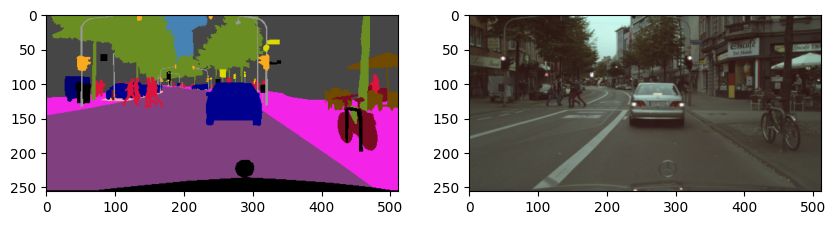

torch.Size([1, 19, 256, 512])
torch.Size([256, 512])


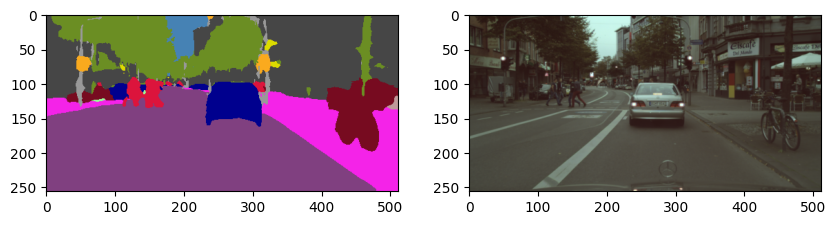

In [6]:
model = ResNetUNet(19)
# torch.hub.load_state_dict_from_url('https://download.pytorch.org/models/resnet18-f37072fd.pth','pretrained')
# state_dict = torch.load("./pretrained/resnet18-f37072fd.pth",map_location='cpu')
# model.load_state_dict(state_dict)

state_dict=torch.load("pretrained/seg_unet.pth", map_location='cpu')
model.load_state_dict(state_dict)

img, sem_gt = dataset_train[15]
plot_img_sem(img,sem_gt)

sem_pred = model(img.unsqueeze(0))
print(sem_pred.shape)
sem_pred=torch.argmax(sem_pred[0], dim=0)
print(sem_pred.shape)
plot_img_sem(img.squeeze(0), sem_pred,from_trainid=True)

plt.imshow(sem_pred)
plt.axis('off')  # Turn off axis labels and ticks if desired
plt.title("DeepLabV3+ Predicition")
plt.savefig('DLV3+pred.png')
plt.close()
plt.show()



torch.Size([3, 256, 512])
torch.Size([256, 512])


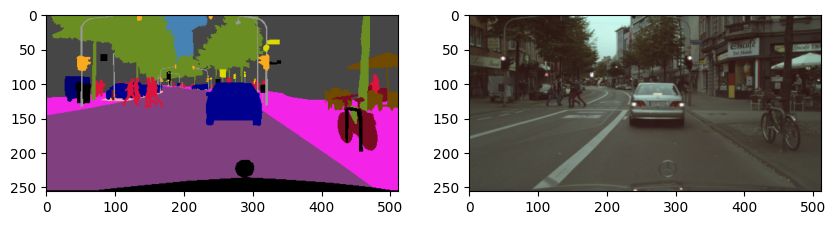

In [7]:
img, sem_gt = dataset_train[15]
print(img.shape)
print(sem_gt.shape)
plot_img_sem(img,sem_gt)#1234->Bus, 1520->Person

# sem_pred = model(img.unsqueeze(0))
# sem_pred=torch.argmax(sem_pred[0], dim=0)
# print(sem_pred.shape)
# plot_img_sem(img.squeeze(0), sem_pred, from_trainid=True)

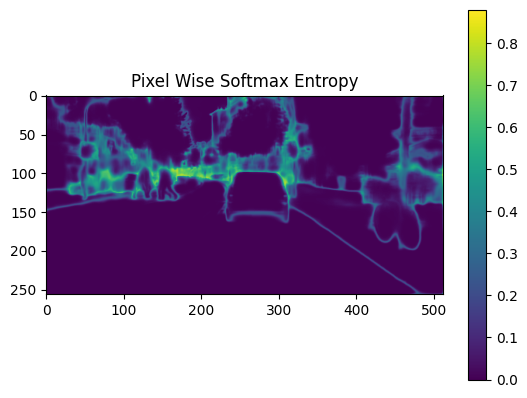

In [8]:
sem_pred = model(img.unsqueeze(0))#infer model
sem_pred_softmax=torch.softmax(sem_pred[0], dim=0)#apply softmax
pixel_wise_softmax_entropy = -torch.sum(sem_pred_softmax * torch.log(sem_pred_softmax), dim=0)#get softmax entropy
log_19 = torch.log(torch.tensor(19.0))#log of number of classes
pixel_wise_softmax_entropy /= log_19#normalize it
pixel_wise_softmax_entropy_np = pixel_wise_softmax_entropy.cpu().detach().numpy()#transform to numpy array
pixel_wise_softmax_entropy_np=np.nan_to_num(pixel_wise_softmax_entropy_np, nan=0)#get rid of nan's
# np.savetxt('whiteSpots.csv', pixel_wise_softmax_entropy_np, delimiter=' ')#save it
plt.imshow(pixel_wise_softmax_entropy_np, cmap='viridis')  # You can choose a different colormap
plt.colorbar()
plt.title('Pixel Wise Softmax Entropy')
plt.show()

torch.Size([19, 256, 512])
torch.Size([256, 512])


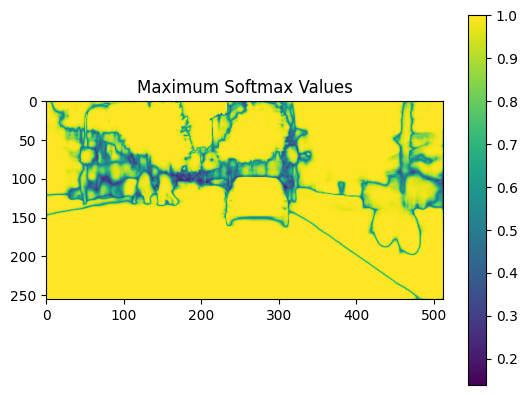

In [9]:
sem_pred = model(img.unsqueeze(0))
sem_pred_softmax=torch.softmax(sem_pred[0], dim=0)
print(sem_pred_softmax.shape)
max_softmax_values, _=torch.max(sem_pred_softmax, dim=0)
print(max_softmax_values.shape)
max_softmax_values_np = max_softmax_values.cpu().detach().numpy()
# np.savetxt('whiteSpots1.csv', max_softmax_values_np, delimiter=' ')
plt.imshow(max_softmax_values_np, cmap='viridis')  # You can choose a different colormap
plt.colorbar()
plt.title('Maximum Softmax Values')
plt.show()

In [10]:
def infer(model):
    torch.manual_seed(88395)
    dataset_val = Cityscapes(root='/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/cityscapes', split='val')
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=4,shuffle=True)
    
    # Get the first batch of images from the dataloader
    batch = next(iter(dataloader_val))
    input_img, labels = batch
    
    # Pass the images through the model to obtain segmentation output logits
    with torch.no_grad():
        logits = model(input_img)
    # Obtain predicted segmentation trainids by argmax over logits
    _, predicted = torch.max(logits, dim=1)
    plot_img_sem(input_img[0].squeeze(0), predicted[0], from_trainid=True)
    plot_img_sem(input_img[1].squeeze(0), predicted[1], from_trainid=True)
    plot_img_sem(input_img[2].squeeze(0), predicted[2], from_trainid=True)
    plot_img_sem(input_img[3].squeeze(0), predicted[3], from_trainid=True)
    return predicted, labels, input_img

In [11]:
# seg_pred, seg_gt, input_img = infer(model_trained)

In [12]:
class SegmentationRunningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))
    # CONF MATRIX
    # 0 1 2 (PRED)
    # 0 |TP FN FN|
    # 1 |FP TP FN|
    # 2 |FP FP TP|
    # (GT)
    # -> rows (axis=1) are FN
    # -> columns (axis=0) are FP
    def iou(self):
        hist = self.confusion_matrix
        true_positives = np.diag(hist)
        false_positives=[]
        false_negatives=[]
        false_negative_sum=np.sum(hist,axis=1)
        false_positive_sum=np.sum(hist,axis=0)
        for i in range (self.n_classes):
            false_negatives.append(false_negative_sum[i]-hist[i,i])
        for i in range (self.n_classes):
            false_positives.append(false_positive_sum[i]-hist[i,i])
        class_iou = true_positives / (true_positives + false_positives +false_negatives)
        class_iou = np.nan_to_num(class_iou, nan=-1) # Convert NaN to -1
        valid_indices = np.where(class_iou >= 0)[0]
        valid_iou = class_iou[valid_indices]
        mean_iou = np.mean(valid_iou) if valid_iou.size > 0 else 0.0
        class_iou_dict = {trainid: iou for trainid, iou in zip(valid_indices,valid_iou)}
        return class_iou_dict, mean_iou
    def fast_hist(self, label_true, label_pred):
        mask=(label_true>=0)&(label_true<self.n_classes)
        hist=np.bincount(
        self.n_classes*label_true[mask].astype(int)+label_pred[mask],minlength=self.n_classes**2,
        ).reshape(self.n_classes, self.n_classes)
        return hist
    def update(self, label_trues, label_preds):
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            self.confusion_matrix += self.fast_hist(label_trues.flatten(),label_preds.flatten())
        
    def get_scores(self):
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            iou, meaniou = self.iou()
        return iou, meaniou
    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))
def val(model):
    torch.manual_seed(88395)
    dataset_val = Cityscapes(root='/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/cityscapes', split='train')
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=4,shuffle=True)
    score=SegmentationRunningScore(19)
    batch_count=0
    for batch in dataloader_val:
        inputs, labels = batch[0], batch[1]
        outputs=model(inputs)
        _,predicted=torch.max(outputs,1)
        predicted=predicted.cpu().numpy()
        labels=convert_id_to_trainid(labels)
        score.update(labels.numpy(), predicted)
        batch_count+=1
        if batch_count==3:
            break
    iou, mean_iou=score.get_scores()
    return iou, mean_iou


In [13]:
#Check mean IoU for trained and untrained UNet
model_trained = ResNetUNet(19)
model_untrained = ResNetUNet(19)

checkpoint_path_trained="/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/weights/UNetResNet_epoch_76_alpha_0.9.pth"
checkpoint_path_untrained="/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_UNetResNet/weights/UNetResNet.pth"

state_dict_trained=torch.load(checkpoint_path_trained)['state_dict']
model_trained.load_state_dict(state_dict_trained)

state_dict_untrained=torch.load(checkpoint_path_untrained)
model_untrained.load_state_dict(state_dict_untrained)

iou_tr, meaniou_tr = val(model_trained)
iou_untr, meaniou_untr = val(model_untrained)

print("Mean IoU trained = {}".format(meaniou_tr))
print("Mean IoU untrained = {}".format(meaniou_untr))

Mean IoU trained = 0.4885244871550924
Mean IoU untrained = 0.6553057172091873


In [16]:
checkpoint_path_trained="/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_DeepLabV3+_WideResNet38/weights/DeepLabV3+_WideResNet38_epoch_3_alpha_0.9.pth"
checkpoint_path_untrained="/work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_DeepLabV3+_WideResNet38/weights/DeepLabV3+_WideResNet38.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Deeplab_trained=load_network("DeepLabV3+_WideResNet38",19,checkpoint_path_trained)
Deeplab_trained=Deeplab_trained.to(device)
Deeplab_untrained=load_network("DeepLabV3+_WideResNet38",19,checkpoint_path_untrained)  
Deeplab_untrained=Deeplab_untrained.to(device)



# state_dict_trained=torch.load(checkpoint_path_trained)
# Deeplab_trained.load_state_dict(state_dict_trained['state_dict'])

# state_dict_untrained=torch.load(checkpoint_path_untrained)
# Deeplab_untrained.load_state_dict(state_dict_untrained['state_dict'])

iou_tr, meaniou_tr = val(Deeplab_trained)
iou_untr, meaniou_untr = val(Deeplab_untrained)

print("Mean IoU trained = {}".format(meaniou_tr))
print("Mean IoU untrained = {}".format(meaniou_untr))


Checkpoint file: /work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_DeepLabV3+_WideResNet38/weights/DeepLabV3+_WideResNet38_epoch_3_alpha_0.9.pth
Load model: DeepLabV3+_WideResNet38... ok
Checkpoint file: /work/pi_noah_daniels_uri_edu/said_harb_uri_edu_data/io/ood_detection/meta_ood_DeepLabV3+_WideResNet38/weights/DeepLabV3+_WideResNet38.pth
Load model: DeepLabV3+_WideResNet38... ok


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacty of 44.38 GiB of which 176.38 MiB is free. Process 3070475 has 9.00 GiB memory in use. Including non-PyTorch memory, this process has 35.21 GiB memory in use. Of the allocated memory 33.26 GiB is allocated by PyTorch, and 637.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [36]:
# IMPORTANT FUNCTIONS
def prediction(net, image):
    image = image
    with torch.no_grad():
        out = net(image)
    if isinstance(out, tuple):
        out = out[0]
    out = out.data.cpu()
    return out

def prediction_softmax(net, image):
    image = image
    with torch.no_grad():
        out = net(image)
    if isinstance(out, tuple):
        out = out[0]
    out = out.data.cpu()
    out = F.softmax(out, 1)
    out=out.squeeze(0)
    sm,_= torch.max(out, dim=0)
    return sm

def prediction_softmax_entropy(net, image):
    image = image
    with torch.no_grad():
        out = net(image)
    if isinstance(out, tuple):
        out = out[0]
    out = out.data.cpu()
    out = F.softmax(out, 1)
    out=out.squeeze(0)
    
    pixel_wise_softmax_entropy = -torch.sum(out * torch.log(out), dim=0)#get softmax entropy
    log_19 = torch.log(torch.tensor(19.0))#log of number of classes
    pixel_wise_softmax_entropy /= log_19
    pixel_wise_softmax_entropy[pixel_wise_softmax_entropy.isnan()] = 0.0
    return pixel_wise_softmax_entropy

cuda


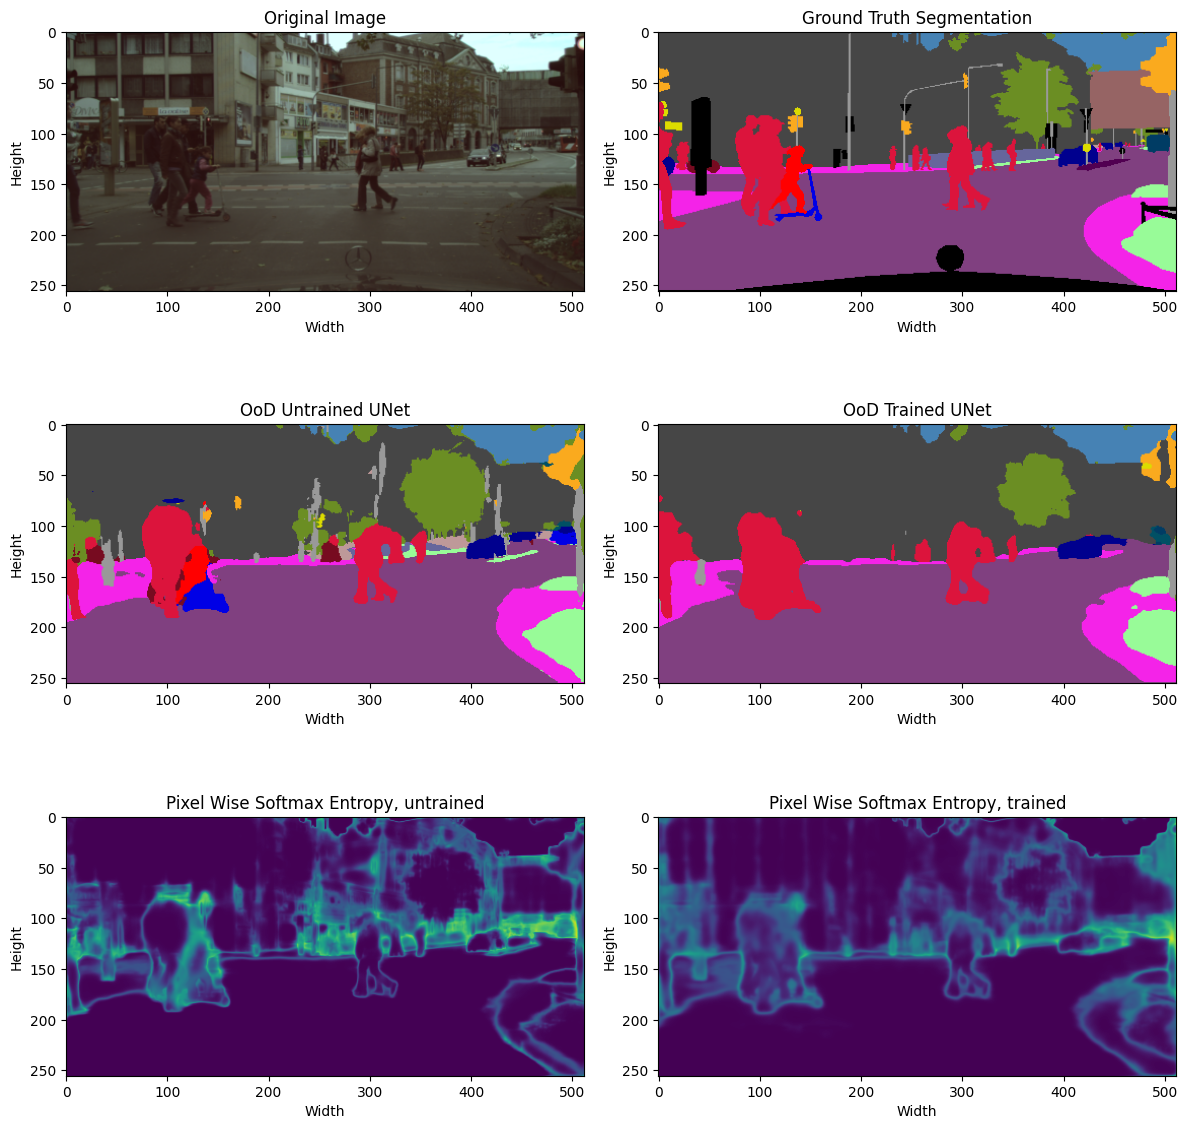

In [45]:
index=14
img, sem_gt = dataset_train[index]

model_trained = model_trained.to(device)
model_untrained = model_untrained.to(device)


image_plot=img
image_plot=image_plot.squeeze(0)
target=sem_gt.squeeze(0)
image = img
with torch.no_grad():
    sem_pred_train = model_trained(image.unsqueeze(0).cuda())
    sem_pred = model_untrained(image.unsqueeze(0).cuda())
sem_pred_train = sem_pred_train.data.cpu()
sem_pred_train=torch.argmax(sem_pred_train[0], dim=0)
sem_pred_train=convert_trainid_to_color(sem_pred_train).numpy()

sem_pred = sem_pred.data.cpu()
sem_pred=torch.argmax(sem_pred[0], dim=0)
sem_pred=convert_trainid_to_color(sem_pred).numpy()
target=convert_id_to_color(target).numpy()
print(device)
#2. Get pixel-wise Softmax Entropy
pixel_wise_softmax_entropy_train = prediction_softmax_entropy(model_trained, image.unsqueeze(0).cuda())
pixel_wise_softmax_entropy_untrain = prediction_softmax_entropy(model_untrained, image.unsqueeze(0).cuda())

#3. Plot Results
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

im0 = axs[0,0].imshow(np.clip(np.transpose(image_plot.numpy(),(1,2,0))*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406]),0,1))
axs[0,0].set_title('Original Image')
axs[0,0].set_xlabel('Width')
axs[0,0].set_ylabel('Height')

im1 = axs[0,1].imshow(target, cmap='viridis')
axs[0,1].set_title('Ground Truth Segmentation')
axs[0,1].set_xlabel('Width')
axs[0,1].set_ylabel('Height')
# fig.colorbar(im1, ax=axs[0])

im2 = axs[1,0].imshow(sem_pred, cmap='viridis')
axs[1,0].set_title('OoD Untrained UNet')
axs[1,0].set_xlabel('Width')
axs[1,0].set_ylabel('Height')
# fig.colorbar(im1, ax=axs[0])

im3 = axs[1,1].imshow(sem_pred_train, cmap='viridis')
axs[1,1].set_title('OoD Trained UNet')
axs[1,1].set_xlabel('Width')
axs[1,1].set_ylabel('Height')
# fig.colorbar(im2, ax=axs[1])

im4 = axs[2,0].imshow(pixel_wise_softmax_entropy_untrain, cmap='viridis')
axs[2,0].set_title('Pixel Wise Softmax Entropy, untrained')
axs[2,0].set_xlabel('Width')
axs[2,0].set_ylabel('Height')
# fig.colorbar(im2, ax=axs[1])

im5 = axs[2,1].imshow(pixel_wise_softmax_entropy_train, cmap='viridis')
axs[2,1].set_title('Pixel Wise Softmax Entropy, trained')
axs[2,1].set_xlabel('Width')
axs[2,1].set_ylabel('Height')

plt.tight_layout()
plt.show()

In [15]:
#"Normal" Training
model_path = 'result/weightsExperiment.pth'
SEG_CLASS_WEIGHTS = (
    2.8149201869965, 6.9850029945374, 3.7890393733978, 9.9428062438965,
    9.7702074050903, 9.5110931396484, 10.311357498169, 10.026463508606,
    4.6323022842407, 9.5608062744141, 7.8698215484619, 9.5168733596802,
    10.373730659485, 6.6616044044495, 10.260489463806, 10.287888526917,
    10.289801597595, 10.405355453491, 10.138095855713
)
def print_model_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'Parameter name: {name}')
            # print(param.data)
            print('-' * 30)
            
def get_model(train=False):
    torch.manual_seed(88395)
    model = ResNetUNet(19)
    if train:
        model.train()
        dataset = Cityscapes(root='/home/said_harb_uri_edu', split="train")
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=4,shuffle=True)
        criterion = nn.CrossEntropyLoss(ignore_index=255)#, weight=torch.tensor(SEG_CLASS_WEIGHTS))
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        for epoch in range(100):
            running_loss = 0.0
            j=0
            
            for batch in dataloader:
                j+=1
                inputs, labels = batch[0], batch[1]
                optimizer.zero_grad()
                
                sem_train_class_id=convert_id_to_trainid(labels)
                outputs = model(inputs)
                loss = criterion(outputs, sem_train_class_id)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                if j%10==0:
                    if j>=20: break
            epoch_loss = running_loss / len(dataloader)
            print(f"Epoch {epoch + 1} Loss: {epoch_loss}")
            sem_pred=model(img.unsqueeze(0))
            sem_pred=torch.argmax(sem_pred[0], dim=0)
            plot_img_sem(img.squeeze(0), sem_pred, from_trainid=True, save=True, name='train'+str(epoch))
            torch.save(model.state_dict(), model_path)
            print(f"Trained model saved to {model_path}")
            
    else:
        model.eval()
    return model

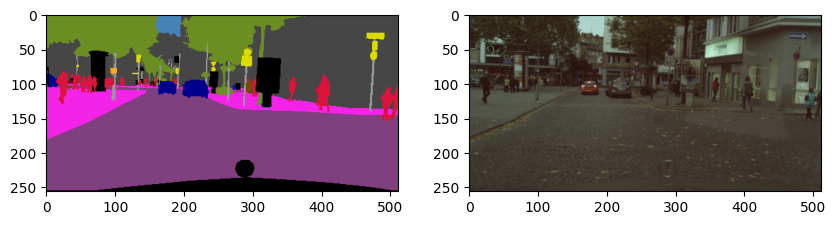

In [46]:
img, sem_gt = dataset_train[111]
plot_img_sem(img, sem_gt, from_trainid=False, save=True, name='ground truth')
             
# model_train=ResNetUNet(19)
# state_dict_train=torch.load("result/weights.pth", map_location='cpu')
# model_train.load_state_dict(state_dict_train)
# print("IOU randomly initialized model\n:")
# # val(model_train)
# sem_pred1 = model_train(img.unsqueeze(0))
# sem_pred1=torch.argmax(sem_pred1[0], dim=0)
# plot_img_sem(img.squeeze(0), sem_pred1)

# model = ResNetUNet(19)
# state_dict=torch.load("pretrained/seg_unet.pth", map_location='cpu')
# model.load_state_dict(state_dict)
# print("IOU pretrained model\n:")
# # val(model)
# sem_pred = model(img.unsqueeze(0))
# sem_pred=torch.argmax(sem_pred[0], dim=0)
# plot_img_sem(img.squeeze(0), sem_pred,from_trainid=True, save=True, name='sdff')


In [23]:


trained_model = get_model(train=False)

iou, meaniou = val(trained_model)

5.2251293327678124e-05


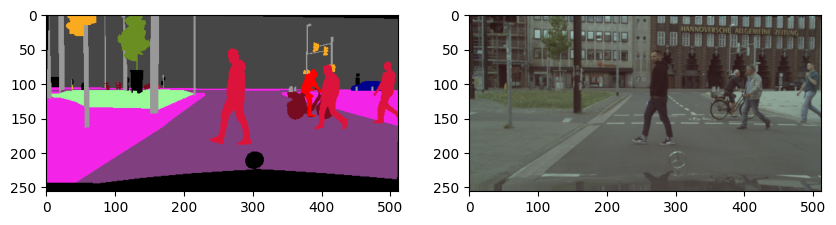

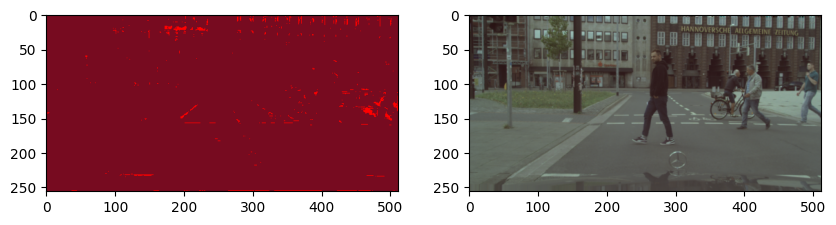

5.2251293327678124e-05


/home/said_harb_uri_edu/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/said_harb_uri_edu/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


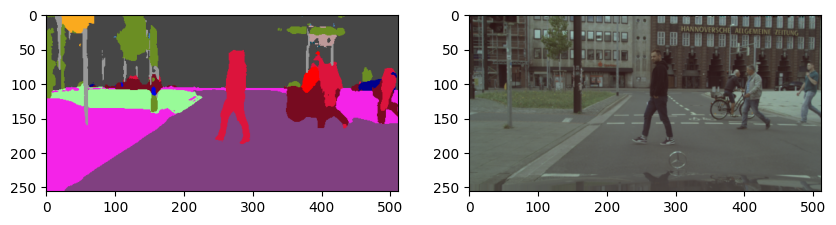

0.6553057172091873


({0: 0.9822210569294446,
  1: 0.8679500577525988,
  2: 0.8491705808152838,
  3: 0.707288965715932,
  4: 0.23527324343506031,
  5: 0.31829009206206144,
  6: 0.31615807903951976,
  7: 0.6386118461225321,
  8: 0.8728203487442009,
  9: 0.8610469183963364,
  10: 0.8884271947661568,
  11: 0.474884279101663,
  12: 0.35772357723577236,
  13: 0.8910079263953931,
  14: 0.8948453608247423,
  15: 0.7664359861591695,
  16: 0.9366986097988932,
  17: 0.4463452566096423,
  18: 0.1456092470701557},
 0.6553057172091873)

In [24]:

img, sem_gt = dataset_train[1520]
plot_img_sem(img,sem_gt)
sem_pred = trained_model(img.unsqueeze(0))
sem_pred=torch.argmax(sem_pred[0], dim=0)
plot_img_sem(img.squeeze(0), sem_pred,from_trainid=True)
# seg_pred, seg_gt, input_img = infer(trained_model)
# seg_pred, seg_gt, input_img = infer(trained_model)
val(trained_model)

model = ResNetUNet(19)
state_dict=torch.load("pretrained/seg_unet.pth", map_location='cpu')
model.load_state_dict(state_dict)
sem_pred = model(img.unsqueeze(0))
sem_pred=torch.argmax(sem_pred[0], dim=0)
plot_img_sem(img.squeeze(0), sem_pred,from_trainid=True)
# seg_pred, seg_gt, input_img = infer(model)
val(model)
